# Model Fit and Image Comparison Pipeline

The purpose of this notebook is to load a series of images fit blindly to data and compare the following metrics:

* Ring properties, such as

    * Radius
    * Width
    * Asymmetry
    * Intensity profiles along the ring
    * Flux inside the ring vs flux outside the ring
    * ...and more

Geometric properties, such as the radius, will be fit using a Hough transfrom and the `HoughTransform` library. Asymmetry, ring width, and flux inside and outside the ring will be determined using the `PontiFEX` library. 

These attributes are ring-specific. 


### 1. Load images.
Please provide your images and model fits as a .fits file, named as [naming convention]. For those submitting multiple images or model fits, please [multiple submission naming convention].

Note: proposed naming convention, will be used for now: `LastnameFirstname_YYMMDD_ID.fits`, where

 * `Lastname`, `Firstname` (self explanatory) ex: JohnsonMichael
 * `YYMMDD`, date of SUBMISSION (e.g. November 8th, 2018 becomes 181108)
 * `ID`, dataset ID unique to each challenge. For the first challenge, this tag is: `WCROMH`. See: https://docs.google.com/spreadsheets/d/11oCD7T6okr3iRfJjvlFesowY3O8QLhv87HbOpP79v3c/edit?usp=sharing
 
 Example submission file name: `JohnsonMichael_181108_WCROMH.fits`

In [21]:
## imports ##
import glob
import numpy
import Pontifex
import itertools
import ehtim as eh
import seaborn as sns
import HoughTransform

## graph settings ##
import matplotlib.pyplot as plt
import matplotlib
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.linewidth'] = 2 #set the value globally
plt.rcParams["font.weight"] = "bold"
plt.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']
matplotlib.rcParams.update({'errorbar.capsize': 4})
cycol = itertools.cycle(sns.color_palette())

## ignore warnings ##
import warnings
warnings.filterwarnings('ignore')


## settings ##
RUN_ALL = True

In [25]:
## quick class to store image submissions() and store the results of their analysis ##
class Submission(object):
    
    def __init__(self, _filepath, run_all_analyses=False):
        ## pre-analysis attributes ##
        print "Working on this file > ", _filepath
        self._filepath      = _filepath
        self.submitter      = self._filepath.split('/')[-1].split('_')[0]
        self.submissionDate = int(self._filepath.split('/')[-1].split('_')[1])
        self.challengeID    = self._filepath.split('/')[-1].split('_')[-1].split('.')[0]
        self.image          = self.loadImage(self._filepath)
        self.ImageAnalysisObject = Pontifex.AnalysisObject(self.image, intervals=15)
            
        
        ## post-analysis attributes ##
        self.analysisResults = {
            'radius':-1,
            'center':(0, 0),
            'width':-1,
            'asymmetry':-1,
            'fluxInside':-1,
            'fluxOutside':-1,
            'fluxInRing':-1,
            'fluxInDepression':-1,
            'orientation':-1,
            'sharpness':-1
        }
        
        ## intensity profiles in the cardinal directions ##
        self.intensityProfiles = {
            0:self.ImageAnalysisObject.intensityProfiles[0],
            1:self.ImageAnalysisObject.intensityProfiles[1],
            2:self.ImageAnalysisObject.intensityProfiles[2],
            3:self.ImageAnalysisObject.intensityProfiles[3]
        }
        
        if run_all_analyses is True: self.runAll()
        
        
    def loadImage(self, _fp):
        return eh.image.load_image(_fp)

    def runAll(self):
        ## run all the analyses ##
        self.getRadius()
        self.getAsymmetry()
        self.getWidth()
        self.fluxInside()
        self.fluxOutside()
        self.sharpness()
    
    def getRadius(self):
        ## use PontiFEX to get the mean radius ##
        while 1:
            try:
                self.ImageAnalysisObject.iterative_peak_finding()
                break
            except ValueError:
                self.ImageAnalysisObject.iterative_peak_finding()
        self.analysisResults['radius'] = self.ImageAnalysisObject.radius_dictionary['combined']
        
    def getAsymmetry(self):
        ## use PontiFEX to get the asymmetry ##
        self.analysisResults['asymmetry'] = self.ImageAnalysisObject.get_asymmetry()
    
    def getWidth(self):
        ## use PontiFEX to get the mean width ##
        self.analysisResults['width'] 
        self.ImageAnalysisObject.get_mean_width()
    
    def fluxInside(self):
        ## use PontiFEX to get the flux inside ##
        self.analysisResults['fluxInside'] = self.ImageAnalysisObject.get_flux_inside_radius()
    
    def fluxOutside(self):
        ## use PontiFEX to get the flux outside ##
        self.analysisResults['fluxOutside'] = self.ImageAnalysisObject.get_flux_outside_radius()
    
    def plot_radius(self):
        self.ImageAnalysisObject.get_radius_CIRCUMCENTER_METHOD()
        plt.imshow(self.image.imvec.reshape((self.image.xdim, self.image.ydim)), interpolation='gaussian', cmap='gray')
        center = self.ImageAnalysisObject.centers['circumcenter']
        circle1 = plt.Circle(center,self.ImageAnalysisObject.uas_to_pix( self.ImageAnalysisObject.radius_dictionary['combined'] ),color='r', label='ring', fill=False)
        plt.gcf().gca().add_artist(circle1)
        
        plt.legend()
        plt.show()
        
    ## under construction ##
    def fluxInRing(self):
        ## use PontiFEX to get the flux in the ring ##
        print 'get the flux within the ring'
    
    def fluxInRingDepression(self):
        ## use PontiFEX to get the flux contained inside the ring but not part of the ring ##
        print 'get flux within ring depression'
    
    def orientation(self):
        ## get the orientation of the ring ##
        print 'get orientation'
    
    def sharpness(self):
        ## get the sharpness of the ring ##
        sharps = []
        for key in self.intensityProfiles:
            centerY = self.ImageAnalysisObject.centers['circumcenter'][1]
            centerRowSlice = self.intensityProfiles[key][:int(centerY)]
            sharps.append(Pontifex.FWHM(range(len(centerRowSlice)), centerRowSlice)/(2.2*numpy.max(centerRowSlice)))
        self.analysisResults['sharpness'] = numpy.median(sharps)

### 2. Create `Submission` object for each model/image.

A submission object allows us to calculate and memoize many different ring-related metrics for each model fit, which we can compare later. One of the biggest benefits is that you can use any metric extraction method you like (here we use `PontiFEX` and `Hyperion`), but you don't have to change any of the actual scripts, just the class. To use your own feature extraction metrics, have your function return a single quantity that can be added to the analysis dictionary `analysisResults`. 

In [30]:
%%capture 
## ^ uncomment when everything is working ##

## load images from folder ##
_imagesFilepath = './sample_images/'
imageFiles = glob.glob(_imagesFilepath + '*.fits')

## create a submission object for each image ##
submissionsList = [Submission(_file, run_all_analyses=RUN_ALL) for _file in imageFiles]

### 3. Run analyses.

Once the features for each `Submission` have been extracted and memoized, perform any statistical analyses you like on them using the `Submission` object's `self.analysisResults` dict. Below are two examples of 

(array([38, 44, 55]),)
(array([41, 57]),)
(array([36, 43, 59]),)


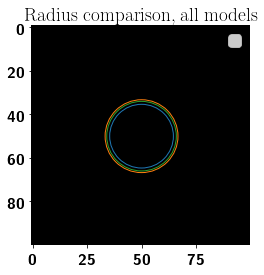

In [31]:
## visual analysis of radius ##
# potential TODO: make all circles centered?
plt.imshow(0*submissionsList[0].image.imvec.reshape((submissionsList[0].image.xdim, submissionsList[0].image.ydim)), interpolation='gaussian', cmap='gray')
for submission in submissionsList:
    submission.ImageAnalysisObject.get_radius_CIRCUMCENTER_METHOD()
    center = (50, 50) #submission.ImageAnalysisObject.centers['circumcenter']
    circle1 = plt.Circle(center,submission.ImageAnalysisObject.uas_to_pix( submission.ImageAnalysisObject.radius_dictionary['combined'] ), color=cycol.next(), label=submission.submitter, fill=False)
    plt.gcf().gca().add_artist(circle1)

plt.legend()
plt.title("Radius comparison, all models")
plt.show()

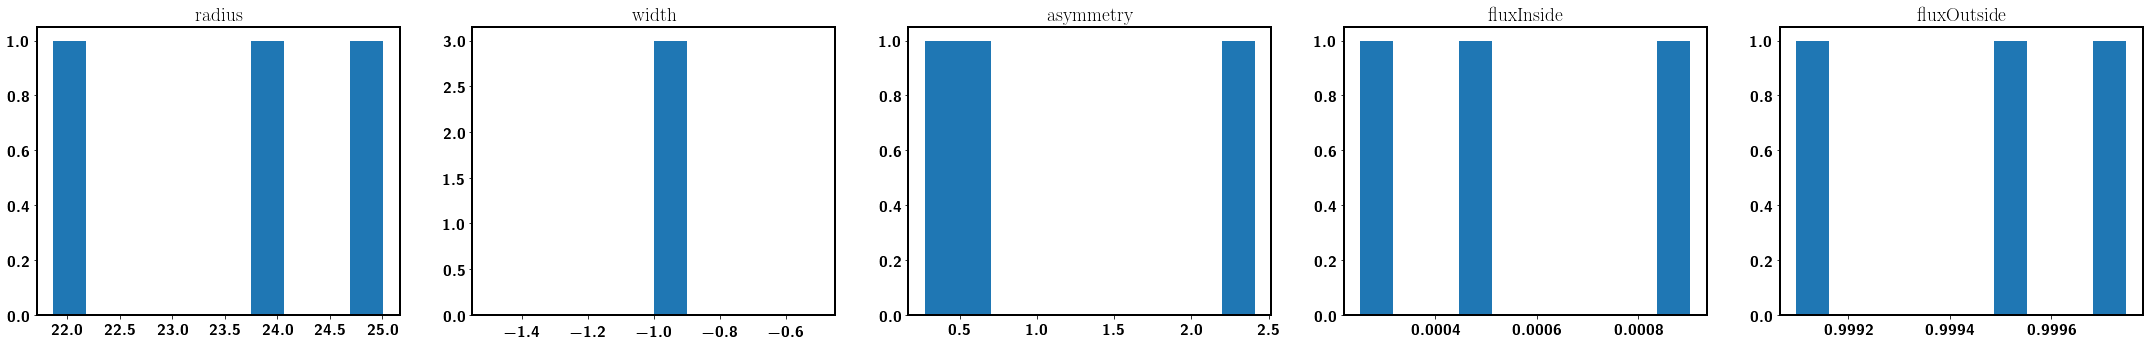

In [32]:
## plotting distributions of the parameters ##
analyses = ['radius', 'width', 'asymmetry', 'fluxInside', 'fluxOutside']

spp = 150

for analysis in analyses:
    spp+=1
    plt.subplot(spp)
    plt.title(analysis)
    plt.hist([submission.analysisResults[analysis] for submission in submissionsList])

plt.subplots_adjust(bottom=1, top=2, right=5)
plt.show()

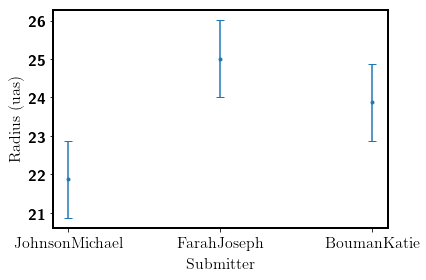

In [33]:
## creating plots of radius and mean width per submission ##
rads = []
widths = []
xticks = []
for submission in submissionsList:
    radius = submission.analysisResults['radius']
    width = submission.analysisResults['width']
    sID = submission.submitter
    rads.append(radius)
    widths.append(width)
    xticks.append(sID)

plt.errorbar(range(len(widths)), rads, yerr=widths, marker='.', linestyle='')
plt.xlabel("Submitter")
plt.ylabel("Radius (uas)")
plt.xticks(range(len(widths)), xticks)
plt.show()

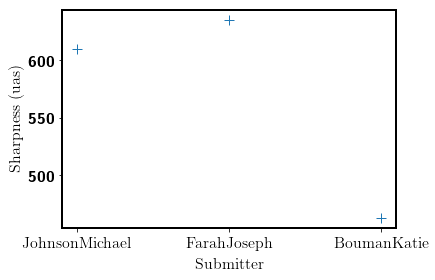

In [39]:
## create plot of ring sharpness for each submission ##
xticks = []
sharpnesses = []
for submission in submissionsList:
    sharpness = submission.analysisResults['sharpness']
    sharpnesses.append(sharpness)
    plt.plot()
    sID = submission.submitter
    xticks.append(sID)

plt.plot(sharpnesses, linestyle='', marker='+', markersize='10')
plt.xlabel("Submitter")
plt.ylabel("Sharpness (uas)")
plt.xticks(range(len(sharpnesses)), xticks)
plt.show()